# Derivation of L2L3 MC corrections


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json

### Change to your xrootd username

In [2]:
xrootdstr = 'root://rappocc@cmsxrootd.fnal.gov/'

### Try the experimental dask processor

Caveat emptor. 

In [3]:
useDask = False

In [4]:
if useDask:
    from distributed import Client
    client = Client('coffea-dask.fnal.gov:8786')

In [5]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class FancyJECL2L3Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 20, -5, 5)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 
                           np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        r_axis = hist.Bin("r", "RECO / GEN response", 200, 0, 5)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'r_pt_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptvm':hist.Hist("Counts", dataset_axis, pt_axis, m_axis, r_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'] * (1 - df['Jet_rawFactor']),
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass'],
            jetId=df['Jet_jetId']
            )        
        
        GenJets = JaggedCandidateArray.candidatesfromcounts(
            df['nGenJet'],
            pt=df['GenJet_pt'],
            eta=df['GenJet_eta'],
            phi=df['GenJet_phi'],
            mass=df['GenJet_mass']
            )
        
        
        evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        output['cutflow']['all events'] += Jets.size

        jetId_cut = (Jets.jetId > 0)        
        Jets = Jets[jetId_cut]
        output['cutflow']['>=1 with loose id'] += jetId_cut.any().sum()
        twoJets = (Jets.counts >= 2)        
        output['cutflow']['>=2 reco jets'] += twoJets.sum()
        twoGens = (GenJets.counts >= 2)
        output['cutflow']['>=2 gen jets'] += twoGens.sum()
        
        Jets = Jets[twoJets & twoGens]
        GenJets = GenJets[twoJets & twoGens]
        
        
        dphi_index = Jets.p4[:,0].delta_phi( Jets.p4[:,1] ) > 1.8
        output['cutflow']['dPhi > 1.8'] += dphi_index.sum()
        

        Jets = Jets[dphi_index]
        GenJets = GenJets[dphi_index]
        
        pairing = Jets.p4[:,0:2].cross(GenJets.p4, nested=True)
        metric = pairing.i0.delta_r(pairing.i1)
        
        index_of_minimized = metric.argmin()
        dr_cut = (metric[index_of_minimized] < 0.2)
        best_pairings_that_pass_dr_cut = pairing[index_of_minimized][dr_cut]
        genrecos = best_pairings_that_pass_dr_cut.flatten(axis=1)
        ptresponse = genrecos.i0.pt / genrecos.i1.pt
        
        output['pt'].fill(dataset=dataset,
                            pt=Jets.pt.flatten())
        output['eta'].fill(dataset=dataset, 
                                 eta=Jets.eta.flatten())
        output['r_pt_ptveta'].fill( dataset=dataset, pt=genrecos.i1.pt.flatten(), eta=genrecos.i1.eta.flatten(), r=ptresponse.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [6]:
# Get the sample metadata
samples = json.load( open('samples_qcdflat.json') )

fileset = {}
for sample in samples["samples"]:    
    name, xsec, nevents, files = sample['name'], sample['xsec'], sample['nevents'], sample['files']
    for ifile,file in enumerate(files):
        files[ifile] = xrootdstr + file
    fileset[name] = files

print(fileset)

{'QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8': ['root://rappocc@cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAODv7/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/70000/C872F1CA-32A4-5142-A797-F0B74012609F.root', 'root://rappocc@cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAODv7/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/70000/F1B4A540-81DD-2844-A6FA-7FBB33E202C2.root', 'root://rappocc@cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAODv7/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/70000/26CAA4F0-90F9-CE4D-A012-4CA402835FB0.root', 'root://rappocc@cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAODv7/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/70000/DB8EE05B-CCB6-1743-BAC8-C6E25203A3A6.root', 'root://rappocc@cmsxrootd.fnal.gov//

In [15]:

    
tstart = time.time() 

if not useDask:
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=FancyJECL2L3Processor(),
                                      executor=processor.iterative_executor,
                                      executor_args={
                                          'skipbadfiles':True,
                                          'nano':False, 
                                          'flatten':True, 
                                          'workers': 4},
                                      chunksize=50000, maxchunks=100
                                     )
else:
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=FancyJECL2L3Processor(),
                                      executor=processor.dask_executor,
                                
                                      executor_args={
                                          'skipbadfiles':True,
                                          'client': client, 
                                          'nano':False, 
                                          'flatten':True, 
                                          'workers': 2},
                                      chunksize=50000
                                     )

elapsed = time.time() - tstart
print(output)


{'pt': <Hist (dataset,pt) instance at 0x7f6a41082cd0>, 'eta': <Hist (dataset,eta) instance at 0x7f6a40d8e710>, 'r_pt_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f6a2b5ea410>, 'r_m_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f6a2b7aae50>, 'r_m_ptvm': <Hist (dataset,pt,m,r) instance at 0x7f6a2be508d0>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 4877981, '>=1 with loose id': 4870457, '>=2 reco jets': 4836958, '>=2 gen jets': 4838420, 'dPhi > 1.8': 2290994})}


In [16]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 13948.944352778642


In [17]:
import matplotlib.pyplot as plt

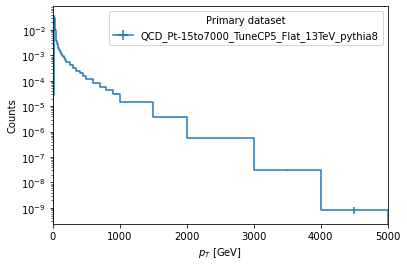

In [18]:
ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False, density=True
                                  #fill_opts=stack_fill_opts,
                                  #error_opts=stack_error_opts,
                                 )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
#fig.show()

In [19]:
plt.rcParams["image.cmap"] = 'Blues'

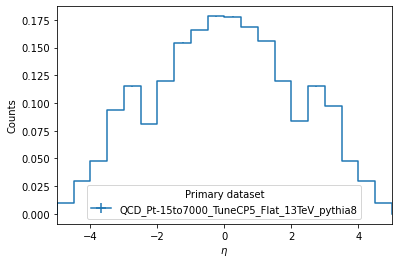

In [20]:
ax = hist.plotgrid(output['eta'], overlay="dataset", stack=False, density=True
                                 )

for iax in ax.flatten():
    iax.autoscale(axis='y')
plt.show()

/opt/conda/lib/python3.7/site-packages/coffea/hist/plot.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1)


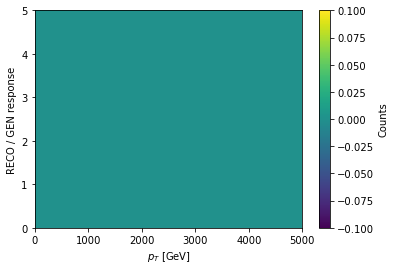

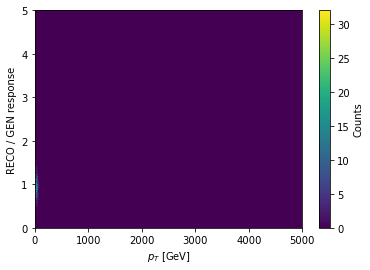

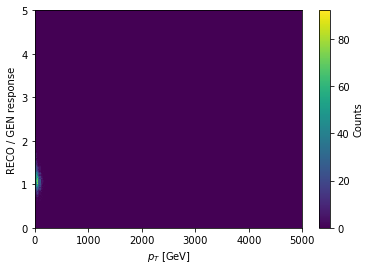

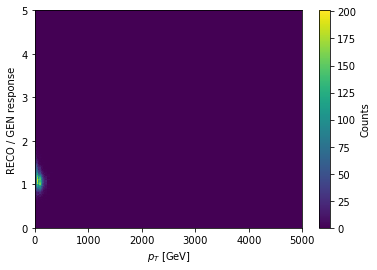

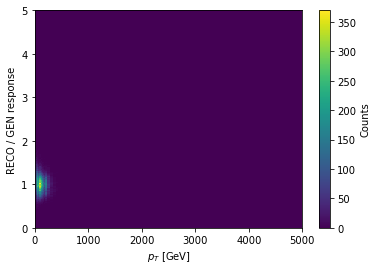

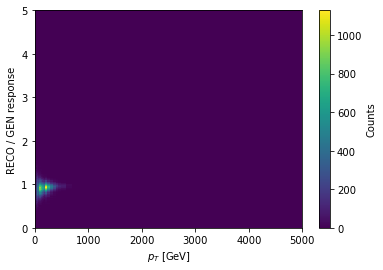

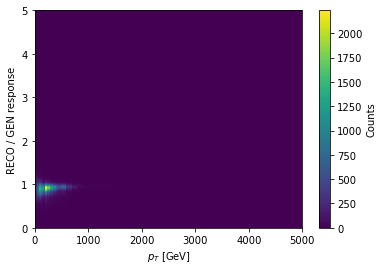

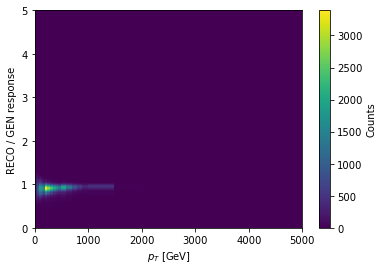

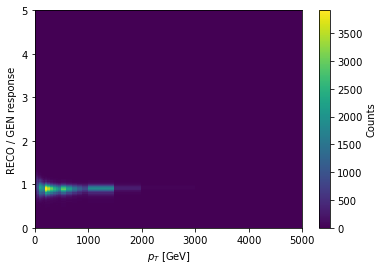

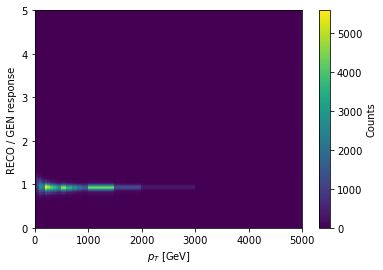

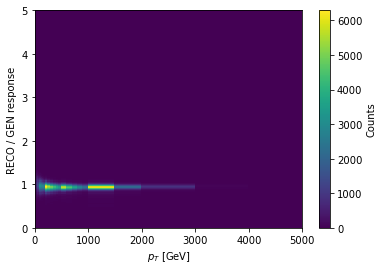

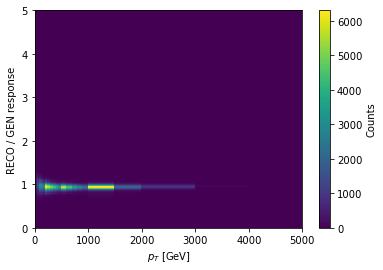

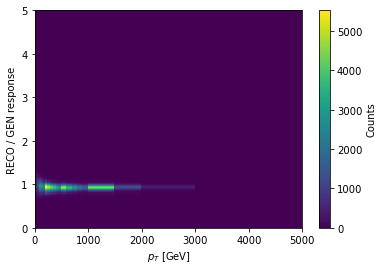

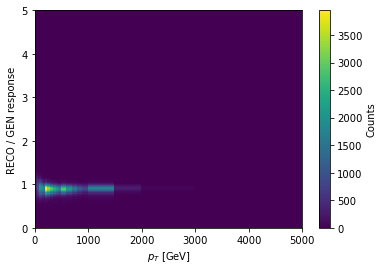

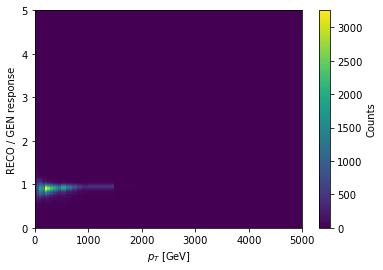

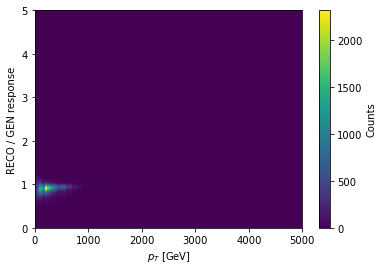

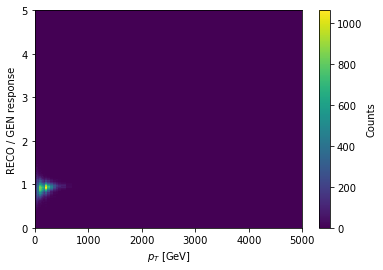

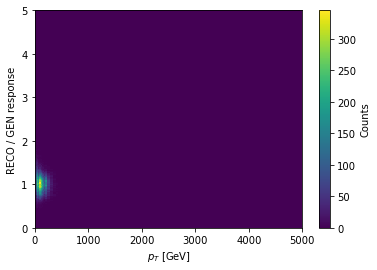

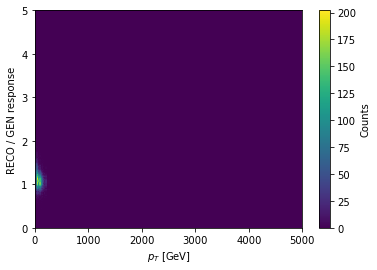

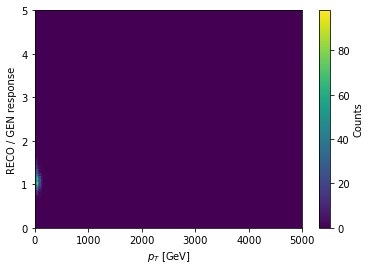

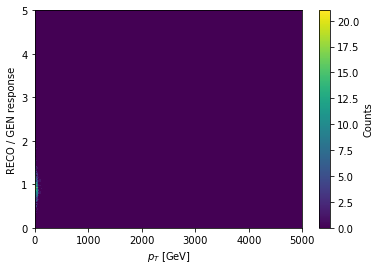

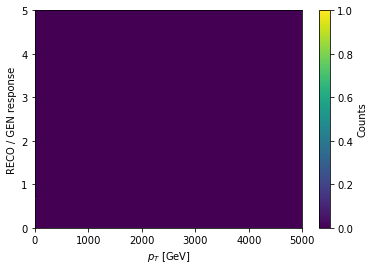

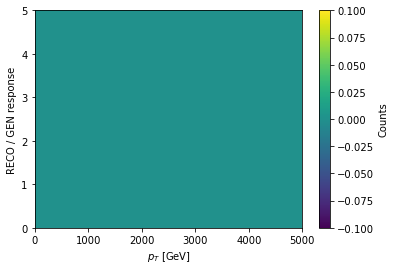

In [21]:


for i in output['r_pt_ptveta'].axis('eta'):
    ax = hist.plot2d(output['r_pt_ptveta'].sum('dataset').integrate('eta', i),xaxis='pt')


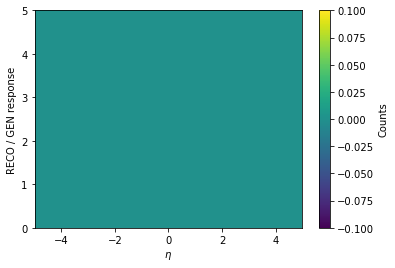

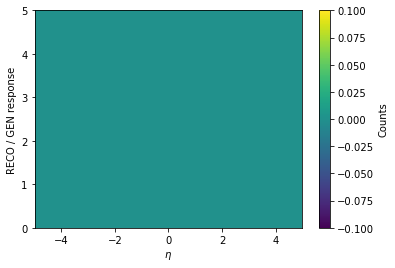

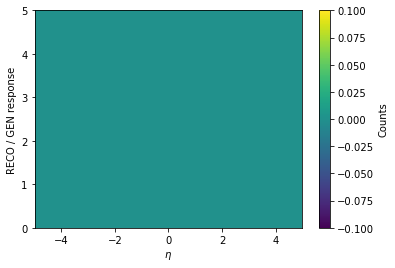

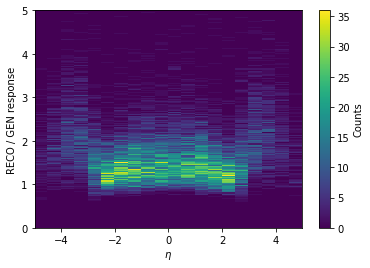

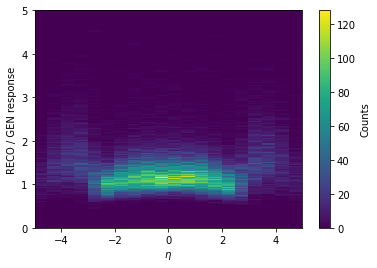

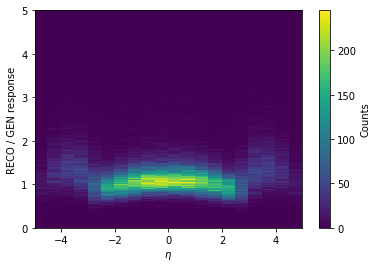

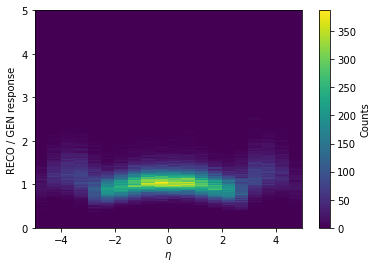

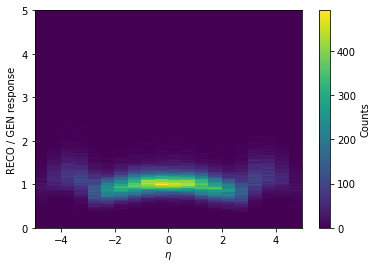

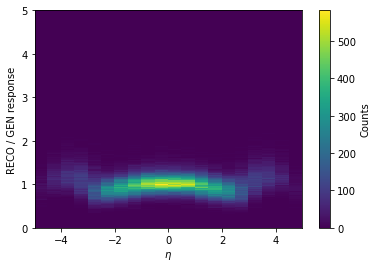

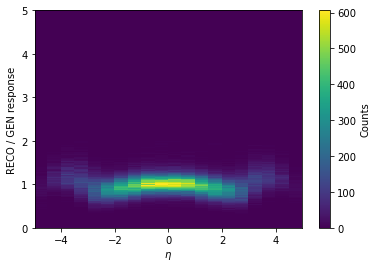

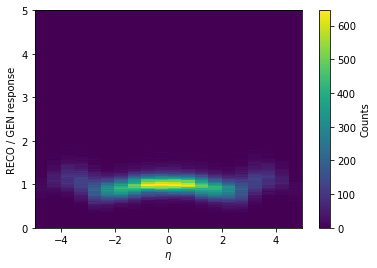

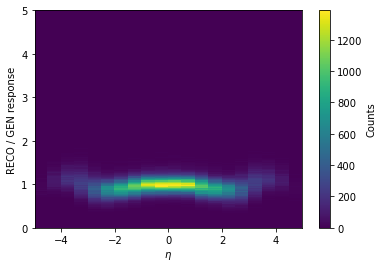

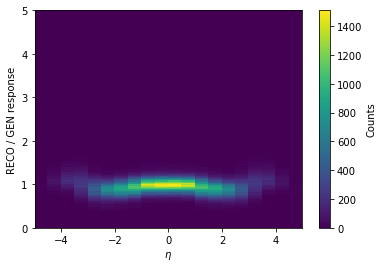

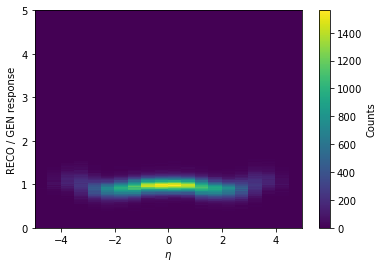

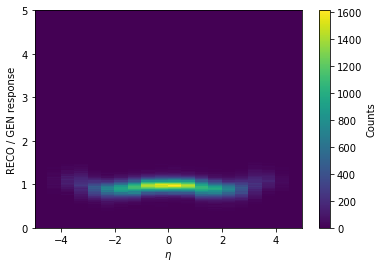

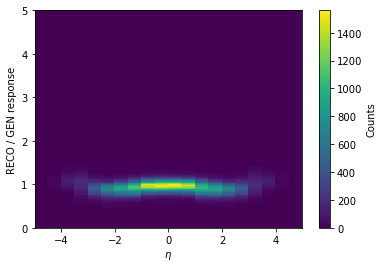

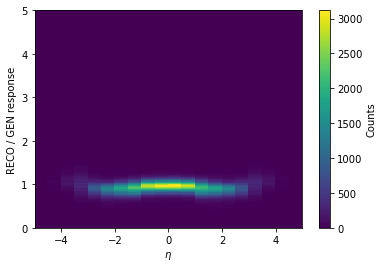

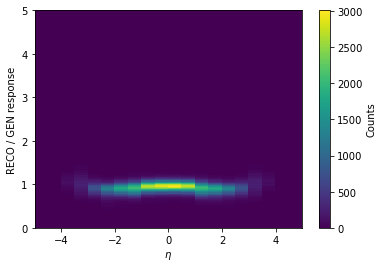

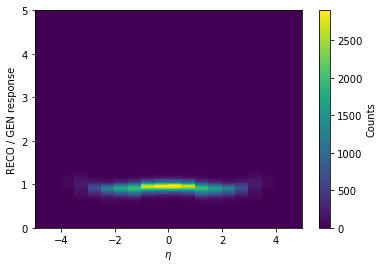

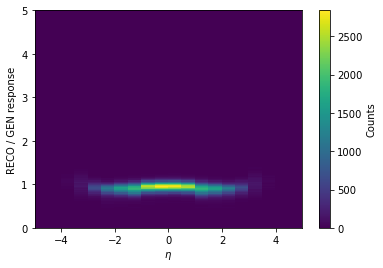

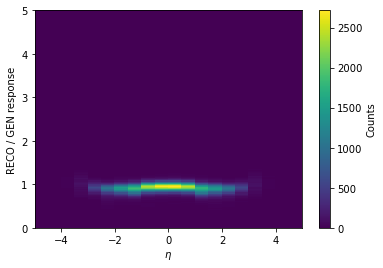

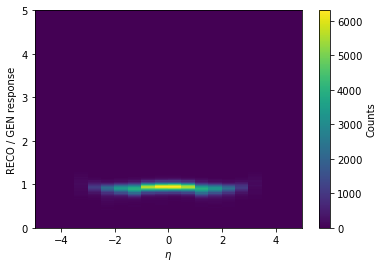

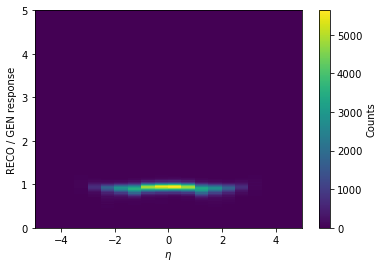

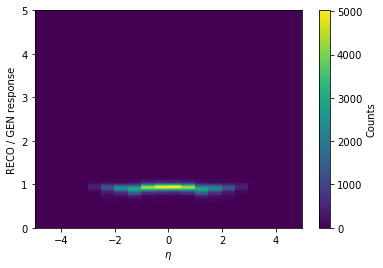

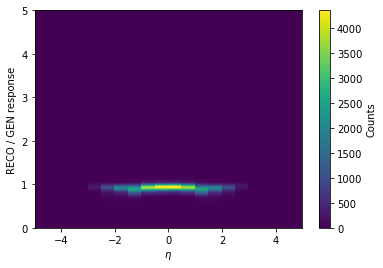

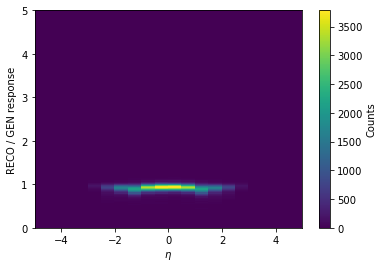

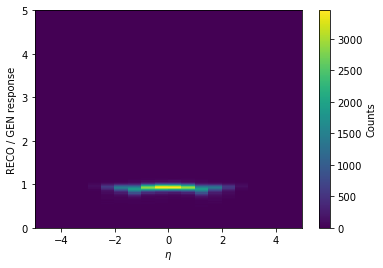

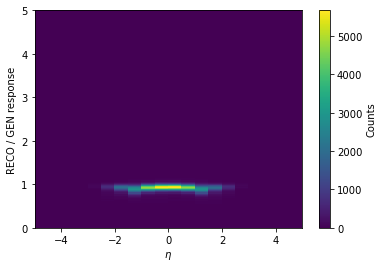

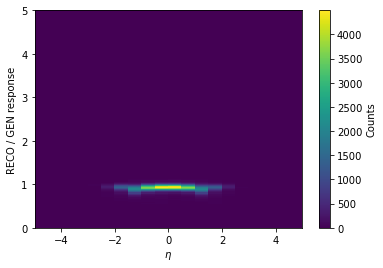

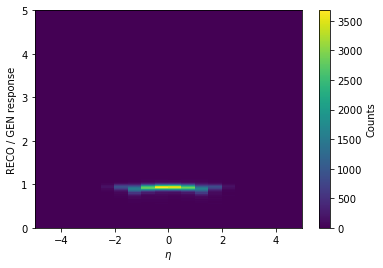

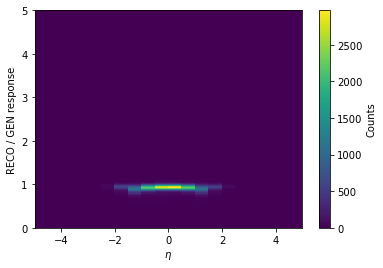

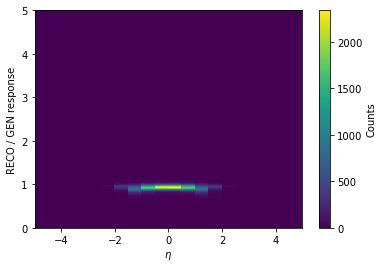

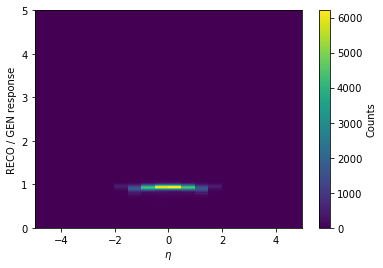

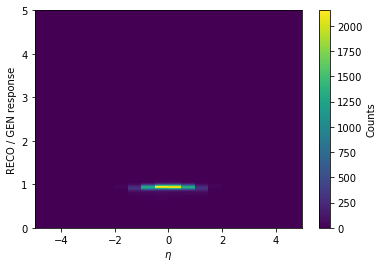

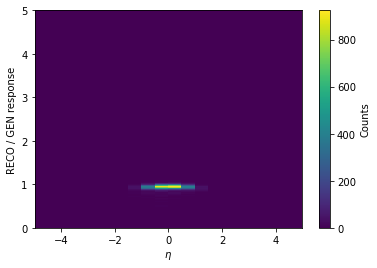

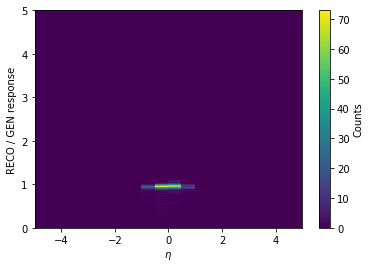

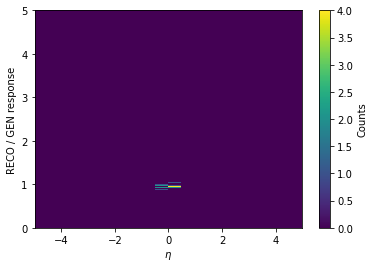

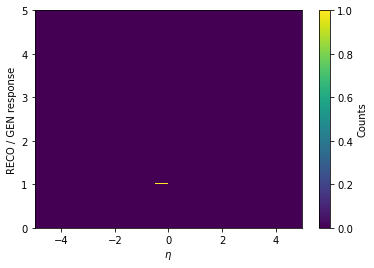

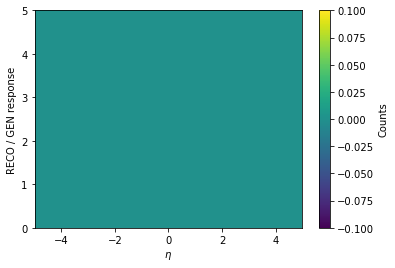

In [22]:
for i in output['r_pt_ptveta'].axis('pt'):
    ax = hist.plot2d(output['r_pt_ptveta'].sum('dataset').integrate('pt',i),xaxis='eta')